Authors: Andrea Proia, Federico Spurio, Cristian Urbinati

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/NLP/project'

/content/drive/.shortcut-targets-by-id/121u2ns7zgxVc05UfWe1-JZYAnrIQ3iH9/NLP/project


# Introduction

# Imports

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Callable, Dict
from collections import OrderedDict
from itertools import groupby
import datetime

import os
import re
import unicodedata
import ast
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
#rom sklearn.metrics import f1_score, accuracy_score
#from sklearn.preprocessing import MultiLabelBinarizer

# Utility functions

In [ ]:
def flat_list(list_to_flatten):
  '''
  Given a list of lists, returns the simple list flattened
  '''
  return [item for sublist in list_to_flatten for item in sublist]

In [ ]:
def clean_claim(claim):
  '''
  Given a claim from the dataset, returns the claim 'cleaned'
  '''
  # Delete links in format [sentence](link)
  claim = re.sub(r'\[|\]|\(http[\w\W]*?[^\\\)][\)]', '', claim).strip().lower()
  # Replace all non words terms with a space and delete \n, \t, \r, \v
  claim = re.sub(r'[^\w\s]|[\n\r\t\v]', ' ', claim).strip()
  # Replace more spaces with only one
  claim = re.sub(r' +', ' ', claim).strip()

  return claim

# Dataset creation
This section can be skipped if the dataframe is loaded from the outside of this notebook

In [ ]:
df = pd.DataFrame()

We create a vocabulary `debates`, that has as keys the names of the directories (named as the general topic), and as value all the name of the files (named as the debates on kialo) related to the general topic 



In [ ]:
debates = {}
for root, dirs, files in os.walk('.'):
  if root == '.':
    continue
   
  debate_names = [debate for debate in files if '.CSV' in debate and 'output' not in debate]
  if debate_names:
    debates[root] = debate_names

print(debates)

{'./palestine': ['palestine.CSV'], './vegan': ['vegan.CSV'], './bull-fight': ['bull-fight.CSV'], './gun-control': ['gun-control.CSV'], './cheating-after-one-night': ['cheating.CSV'], './united-states-europe': ['useurope.CSV'], './nipples': ['nipples.CSV'], './monarchies': ['monarchies.CSV'], './harry-potter': ['harry-potter.CSV'], './alien-existence': ['alien.CSV'], './feminism-is-a-force': ['feminism-is-a-force.CSV'], './free-will-or-determinism': ['free-will-or-determinism.CSV'], './religion': ['people-should-not-follow-any-specific-religion.CSV', 'has-religion-been-a-good-thing-for-humanity.CSV', 'the-existence-of-god.CSV', 'god-exists.CSV'], './ubi': ['ubi.CSV']}


In [ ]:
debate_dir_list = []
for key in debates.keys():
  debate_dir_list.append([key + '/' + d for d in debates[key]])

debate_dir_list = flat_list(debate_dir_list)
print(debate_dir_list)
sep = ';'

['./palestine/palestine.CSV', './vegan/vegan.CSV', './bull-fight/bull-fight.CSV', './gun-control/gun-control.CSV', './cheating-after-one-night/cheating.CSV', './united-states-europe/useurope.CSV', './nipples/nipples.CSV', './monarchies/monarchies.CSV', './harry-potter/harry-potter.CSV', './alien-existence/alien.CSV', './feminism-is-a-force/feminism-is-a-force.CSV', './free-will-or-determinism/free-will-or-determinism.CSV', './religion/people-should-not-follow-any-specific-religion.CSV', './religion/has-religion-been-a-good-thing-for-humanity.CSV', './religion/the-existence-of-god.CSV', './religion/god-exists.CSV', './ubi/ubi.CSV']


We read all the dataset scraped from Kialo, and merge them. After that, we do some preprocessing on the claims 

In [ ]:
for debate in debate_dir_list:
  # The csv files under the religion folder have as separator ',', while the others have ';'
  if 'religion' in debate:
    dataset_csv = pd.read_csv(debate, quotechar='"', sep=',', encoding='cp1252')
  else:
    dataset_csv = pd.read_csv(debate, quotechar='"', sep=sep, encoding='cp1252')
    
  dataset_csv = dataset_csv.drop(columns=['Unnamed: 0'])

  dataset_csv['Claim'] = dataset_csv['Claim'].apply(clean_claim)
  dataset_csv['Debate_name'] = debate.split('/')[2].split('.')[0]
  
  df = df.append(dataset_csv, ignore_index=True)

In [ ]:
df

,Level,Stance,Claim,Votes,Comments,Depth,Debate_name
0,1,None,the us should recognize palestine as a state,"['16', '7', '10', '14', '37']",NaN,0,palestine
1,1.1,pro,the us has an obligation to recognise palestin...,"['1', '0', '0', '0', '0']",5,1,palestine
2,1.1.1,pro,public opinion in the us supports this step mo...,"['0', '0', '0', '0', '0']",3,2,palestine
3,1.1.1.1,pro,two thirds of all americans and even almost ha...,"['1', '1', '4', '10', '1']",,3,palestine
4,1.1.1.1.1,pro,the us historical pattern of vetoing nearly ev...,"['0', '1', '6', '7', '0']",1,4,palestine
...,...,...,...,...,...,...,...
22543,1.7.5.2.1.1,pro,conservatives aren t in favor of higher taxes ...,"['0', '0', '0', '0', '0']",,5,ubi
22544,1.7.5.2.2,pro,a ubi would not necessarily downsize the gover...,"['0', '0', '0', '0', '0']",,4,ubi
22545,1.7.5.2.2.1,con,ubi could at least partially replace some gove...,"['0', '0', '0', '0', '0']",5,5,ubi
22546,1.7.5.2.2.1.1,pro,unlike cash transfers assistance programs like...,"['0', '0', '0', '0', '0']",1,6,ubi


We manipulate the above dataset, adding columns useful for further processing

In [ ]:
# The list of votes of the csv file is a string; 
# this line of code convert the string into a list of integer
df['Votes'] = df['Votes'].apply(lambda x: [int(elem) for elem in ast.literal_eval(x)])
# Calulate the total number of votes obtained by the claim
df['Tot_votes'] = df['Votes'].apply(lambda x: sum(x))

# np.average does not deal with all weights be zeros. So we add a small quantity 
# and later remove entries with zero votes
df['Mean_vote'] = df['Votes'].apply(lambda x: np.average([0,1,2,3,4], weights=[(a + 1e-8) for a in x], axis=0))
df['Mean_vote'] = df['Mean_vote'].apply(lambda x: np.around(x, 1))

# If the number of total votes are zero, we put zero as mean 
# (also because we don't deal with them in the computational part)
df.loc[df['Tot_votes'] == 0, 'Mean_vote'] = 0

In [ ]:
# For each claim, we add columns for the claim, the mean vote and the stance of the parent node
def retrieve_parent_info(level, debate, column_info: str):
  parentLevel = level.rsplit('.', 1)[0]
  return df.loc[(df['Level']  == parentLevel) & (df['Debate_name']  == debate)][column_info].values[0] if (len(parentLevel) > 0) else "None"

In [ ]:
# It takes a while
df["Parent_claim"] = df.apply(lambda row: retrieve_parent_info(row['Level'], row['Debate_name'], 'Claim'), axis=1)
df["Parent_vote"] = df.apply(lambda row: retrieve_parent_info(row['Level'], row['Debate_name'], 'Mean_vote'), axis=1)
df["Parent_stance"] = df.apply(lambda row: retrieve_parent_info(row['Level'], row['Debate_name'], 'Stance'), axis=1)

In [ ]:
# Drop the main claim; it is not generated by users and doesn't have any parent and no stance (used for statistics and predictions)
df = df.drop(df[df['Stance'] == 'None'].index) 
# Drop claims with less than 2 votes
df = df.drop(df[df['Tot_votes'] < 2].index) 

In [ ]:
# Save dataframe to csv
df.to_csv("dataframe.csv", index=False)

# Dataset analysis
In this section we perform some analysis on the dataset to discover relation between some claim features. In particular:
- see if the distribution of the impact (integer and rounded to first decimal) is uniform or there are peaks that suggest is better to use a classifier instead of a regressor
- see if there is a relation between the depth and the number of votes or the impact value

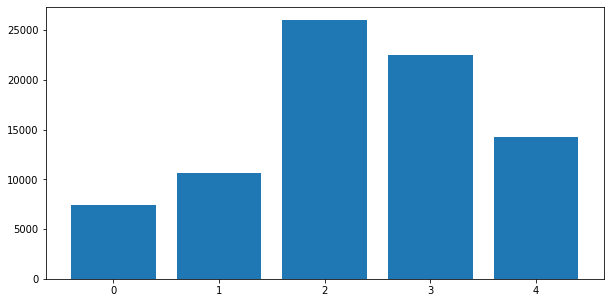

In [ ]:
# The list of votes of the csv file is a string; 
# this line of code convert the string into a list of integer
df['Votes'] = df['Votes'].apply(lambda x: [int(elem) for elem in ast.literal_eval(x)])

def show_histogram_tot_votes(df):
  '''
  Plot the histogram of total singular votes (that are integer between 0 and 4), 
  given a dataframe with column 'Votes'
  '''
  votes = np.zeros(5)
  for v in df['Votes'].values:
    votes += v
    
  votes = [int(v) for v in list(votes)]
  plt.bar(range(0,5), votes)
  plt.show()

show_histogram_tot_votes(df)

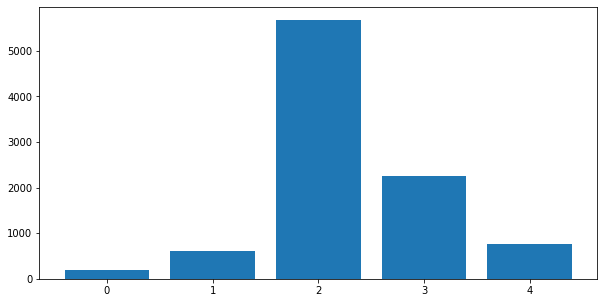

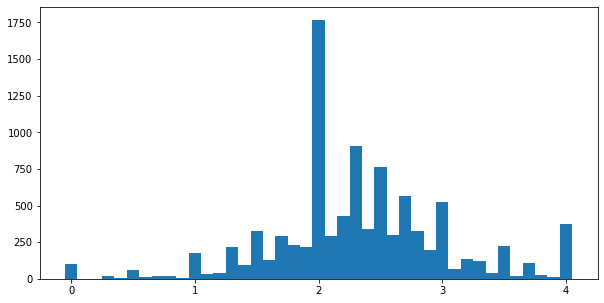

In [ ]:
def show_histogram_mean_votes(df):
  '''
  Plot the histogram of the sum of mean vote of each claim
  '''
  d = df['Mean_vote'].round().values
  plt.bar(*np.unique(d, return_counts=True))
  plt.show()

  d = df['Mean_vote'].values
  plt.bar(*np.unique(d, return_counts=True), width=0.1)
  plt.show()

show_histogram_mean_votes(df)

The distribution in uniformly distributed

Let's see how the number of votes normalized in percentage for each debate and the impact (mean vote) varies with respect to the depth in the tree-structure

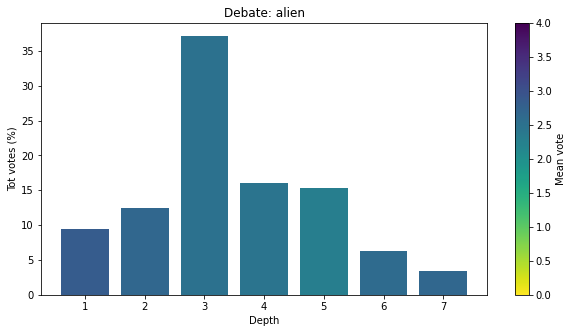

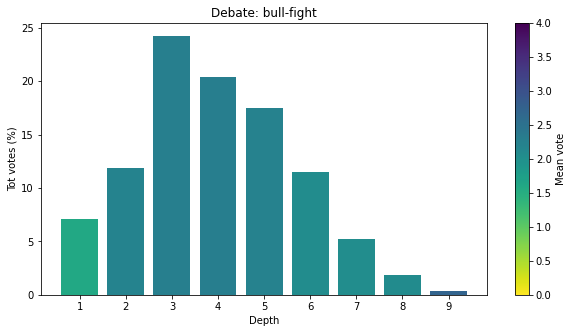

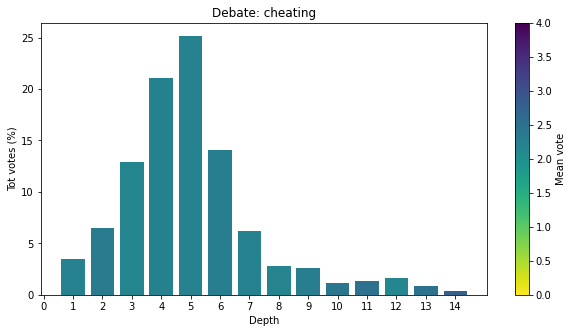

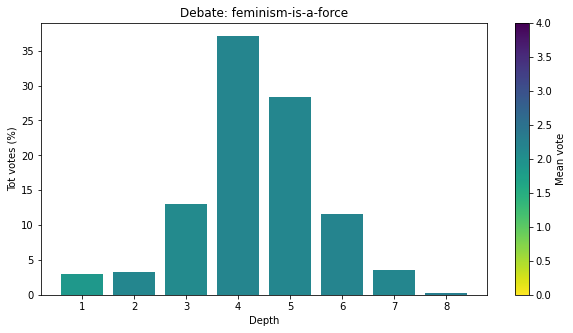

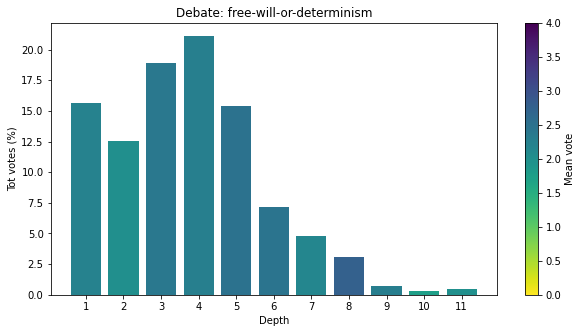

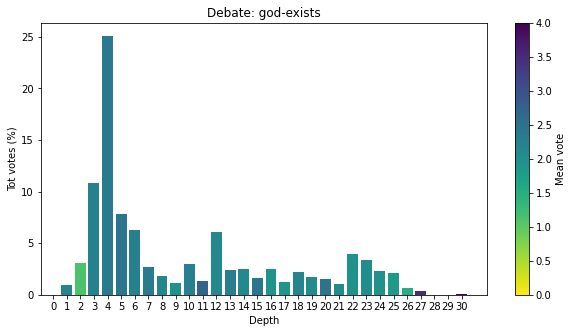

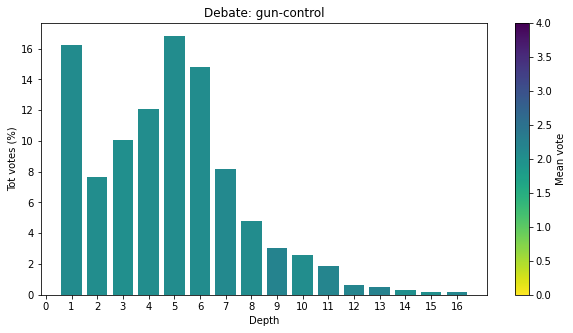

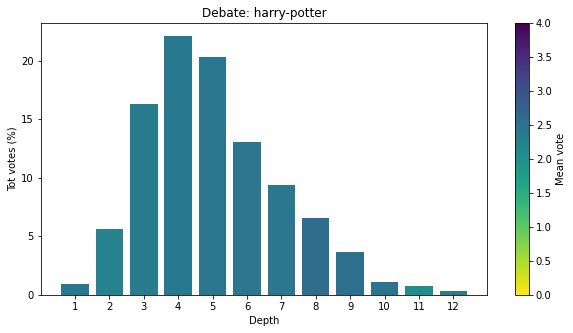

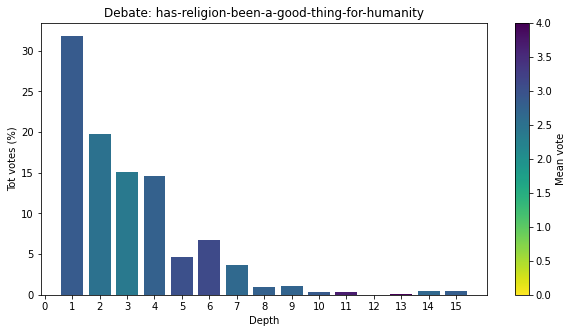

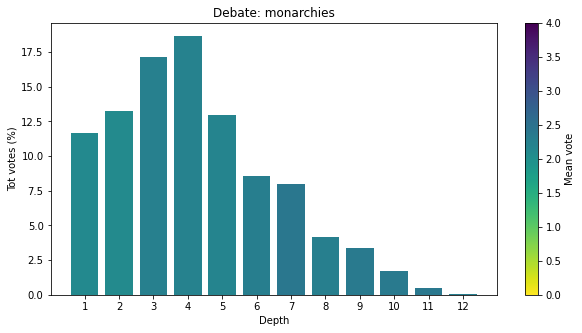

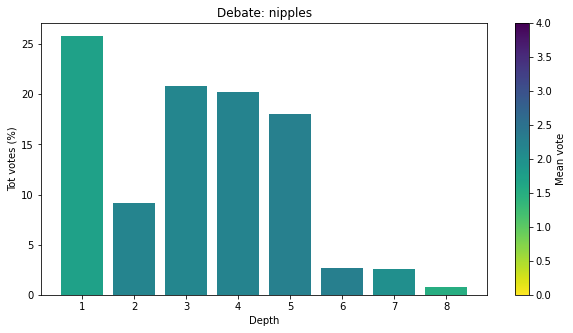

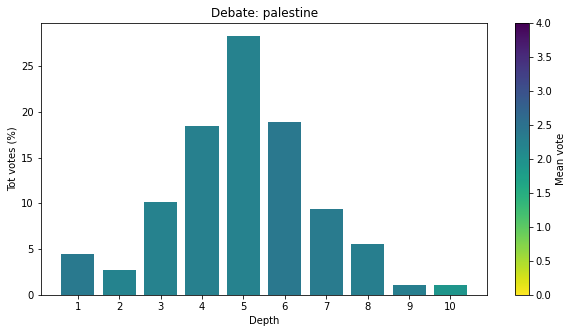

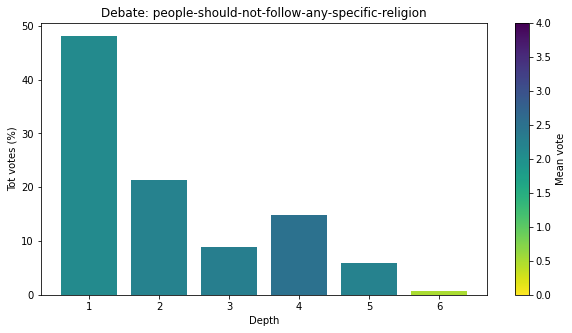

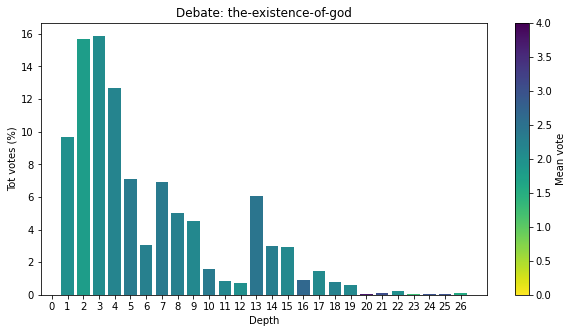

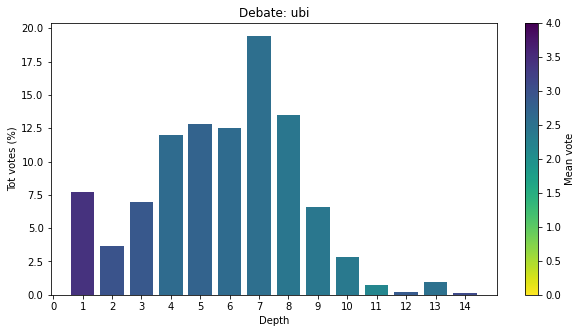

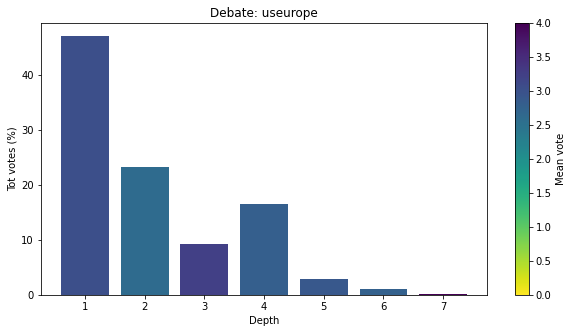

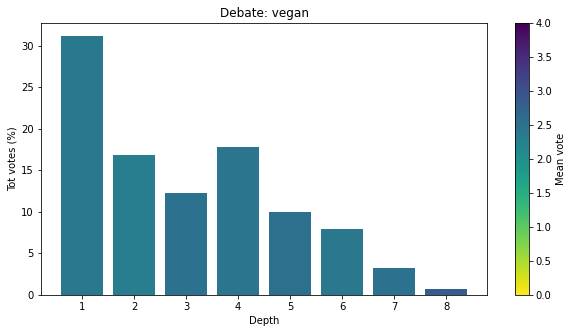

In [ ]:
dabate_vs_totVotes = df[['Debate_name', 'Depth','Tot_votes']].groupby(['Debate_name', 'Depth'], as_index=False).sum()
dabate_vs_meanVote = df[['Debate_name', 'Depth','Mean_vote']].groupby(['Debate_name', 'Depth'], as_index=False).mean()

for debate in dabate_vs_totVotes['Debate_name'].unique():
  depths = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Depth'].values
  tot_votes = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Tot_votes'].values
  mean_vote = dabate_vs_meanVote[dabate_vs_meanVote['Debate_name'] == debate]['Mean_vote'].values

  cmap = mpl.cm.viridis_r
  norm = mpl.colors.Normalize(vmin=0, vmax=4)

  plt.title(f'Debate: {debate}')
  plt.xlabel('Depth')
  plt.ylabel('Tot votes (%)')
  plt.xticks(range(max(depths) + 1))
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Mean vote')
  plt.bar(depths, tot_votes/sum(tot_votes) * 100, color=cmap(norm(mean_vote)))
  plt.show()

There are less votes on claims at lower level but there is not a general rule for the impact.

Let's see if we can observe some patterns in a unique plot that groups all the debates by normalizing also the level in percentage.

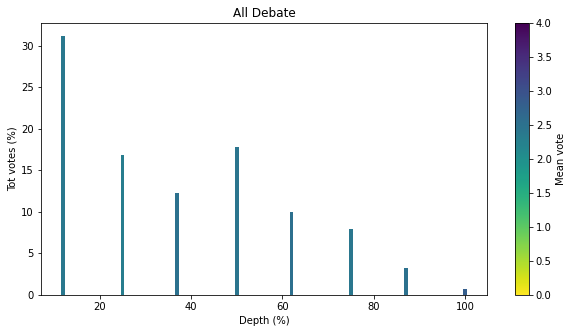

In [ ]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    max = groups.transform("max")
    normalized = df[max.columns] / max * 100
    return normalized.astype(int)

norm_depth = normalize_by_group(df[['Debate_name', 'Depth']], ['Debate_name'])['Depth']
dabate_vs_totVotes = pd.concat([df[['Debate_name','Tot_votes']], norm_depth], axis=1).groupby(['Debate_name', 'Depth'], as_index=False).sum()
dabate_vs_meanVote = pd.concat([df[['Debate_name','Mean_vote']], norm_depth], axis=1).groupby(['Debate_name', 'Depth'], as_index=False).mean()

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=0, vmax=4)

depths = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Depth'].values
tot_votes = dabate_vs_totVotes[dabate_vs_totVotes['Debate_name'] == debate]['Tot_votes'].values
mean_vote = dabate_vs_meanVote[dabate_vs_meanVote['Debate_name'] == debate]['Mean_vote'].values

plt.title(f'All Debate')
plt.xlabel('Depth (%)')
plt.ylabel('Tot votes (%)')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Mean vote')
plt.bar(depths, tot_votes/sum(tot_votes) * 100, color=cmap(norm(mean_vote)))
plt.show()

No relation can be seen, the impact at every level scale is around the mean value.

Next we would like to see if there is a relation between the impact and the number of Pro/Con child for a given claim.

In [ ]:
#It takes a while

def retrieve_child(level, debate, statement):
  '''
  Function that retrieve the total number of child with a given statement for a claim at a certain level of a given debate
  '''
  child_level = f'^({level}\.\d+)$'
  children = df.loc[(df['Level'].str.match(child_level)) & (df['Debate_name']  == debate)]
  return children[children['Stance'] == statement]['Stance'].count() if len(children) > 0 else 0

df_pro_con = df[['Debate_name', 'Level']]
df_pro_con['Pro'] = df_pro_con.apply(lambda row: retrieve_child(row['Level'], row['Debate_name'], 'pro'), axis=1)
df_pro_con['Con'] = df_pro_con.apply(lambda row: retrieve_child(row['Level'], row['Debate_name'], 'con'), axis=1)

df_pro_con

,Debate_name,Level,Pro,Con
0,palestine,1.1.1.1,1,0
1,palestine,1.1.1.1.1,0,0
2,palestine,1.1.1.3.1,0,0
3,palestine,1.1.1.3.3,0,0
4,palestine,1.1.1.4,1,0
...,...,...,...,...
9494,ubi,1.7.4.8.2.3,0,0
9495,ubi,1.7.4.8.3.2.1,0,0
9496,ubi,1.7.4.8.3.2.2,0,0
9497,ubi,1.7.4.8.3.6,0,0


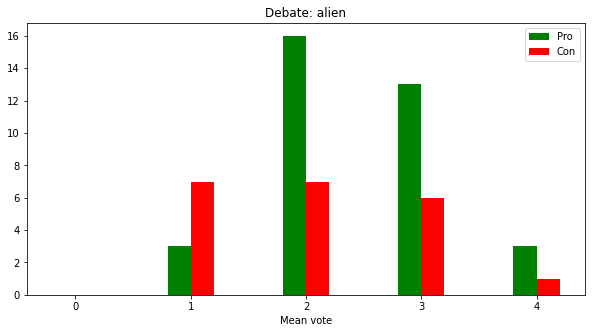

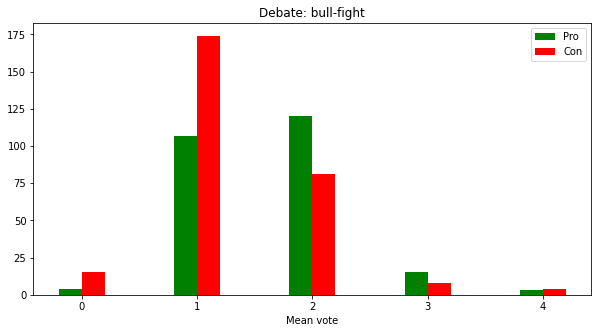

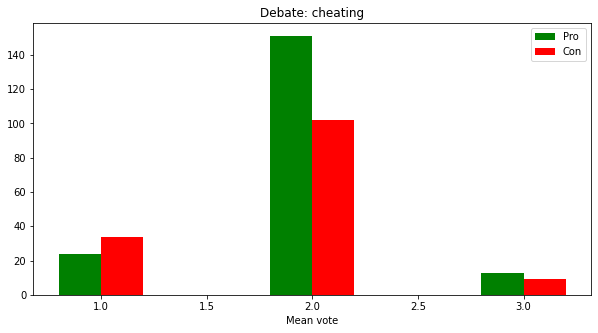

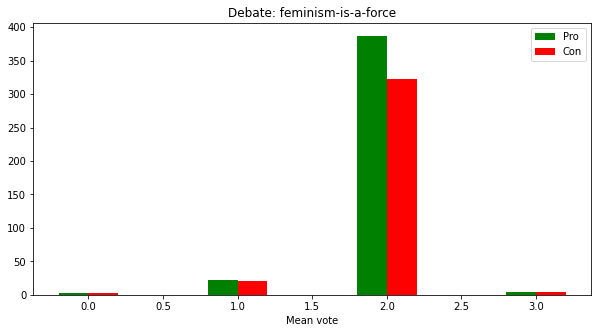

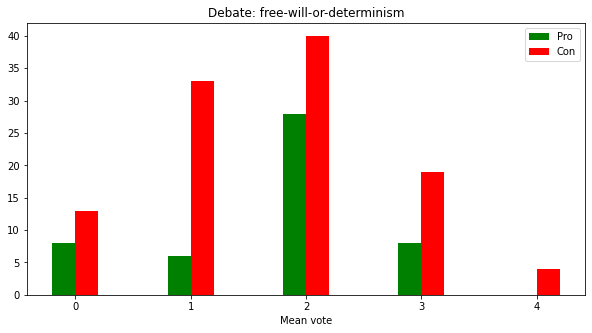

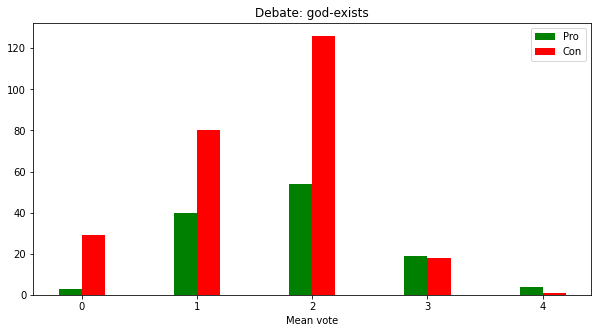

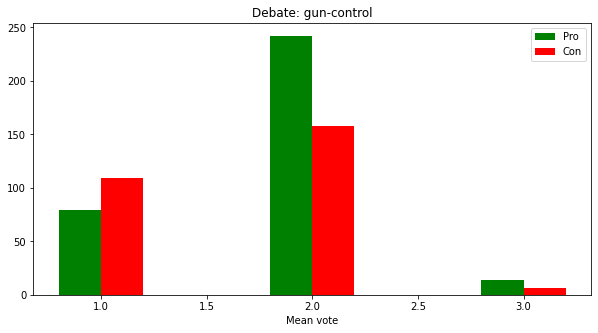

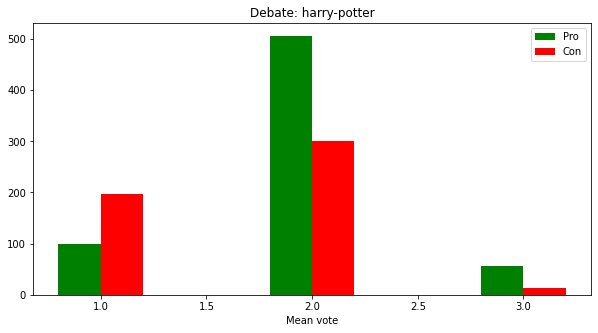

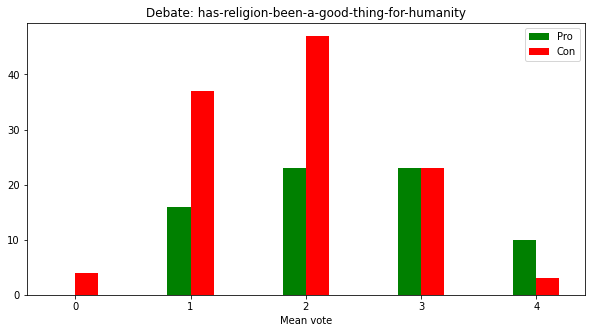

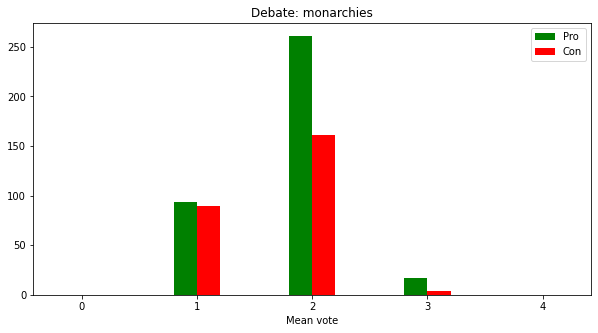

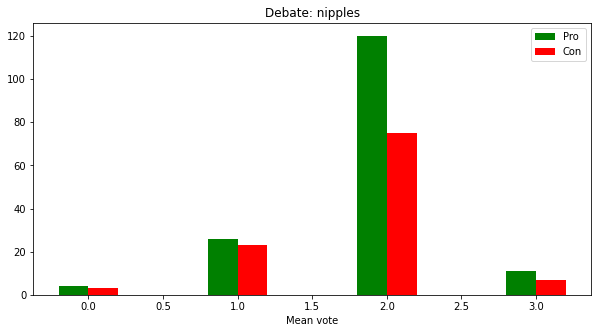

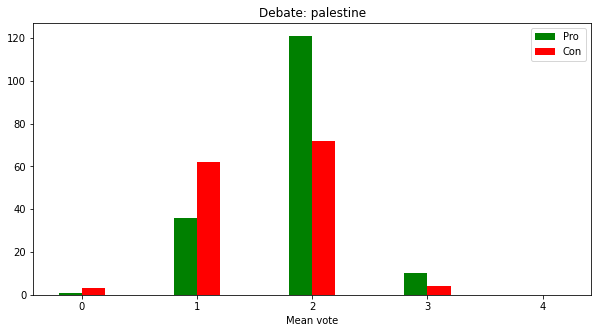

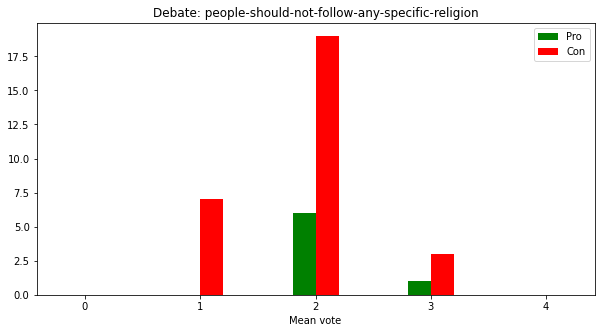

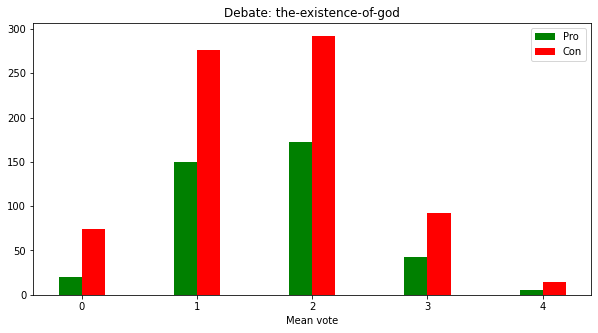

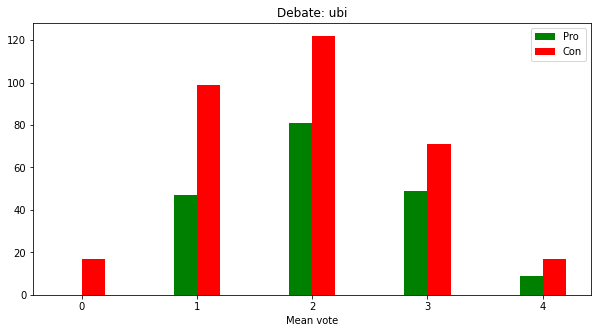

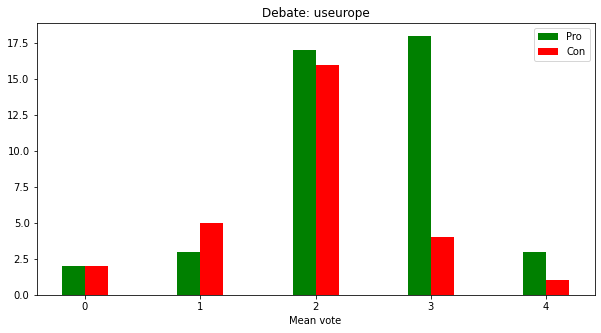

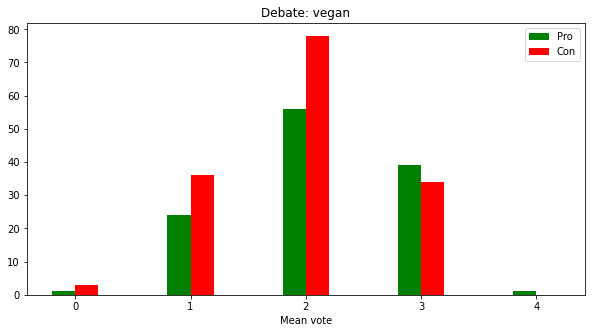

In [ ]:
df_mean_pro_con = pd.concat([df_pro_con[['Debate_name', 'Pro', 'Con']], pd.DataFrame(df['Mean_vote'].values.astype(int), columns=['Mean_vote'])], axis=1) 
df_mean_pro_con = df_mean_pro_con.groupby(['Debate_name', 'Mean_vote'], as_index=False).sum()

for debate in df_mean_pro_con['Debate_name'].unique():
  x = df_mean_pro_con[df_mean_pro_con['Debate_name'] == debate]['Mean_vote'].values
  pro = df_mean_pro_con[df_mean_pro_con['Debate_name'] == debate]['Pro'].values
  con = df_mean_pro_con[df_mean_pro_con['Debate_name'] == debate]['Con'].values

  ax = plt.subplot(111)
  ax.bar(x-0.1, pro, width=0.2, color='g', align='center', label='Pro')
  ax.bar(x+0.1, con, width=0.2, color='r', align='center', label='Con')

  ax.legend()

  plt.title(f'Debate: {debate}')
  plt.xlabel('Mean vote')

  plt.show()

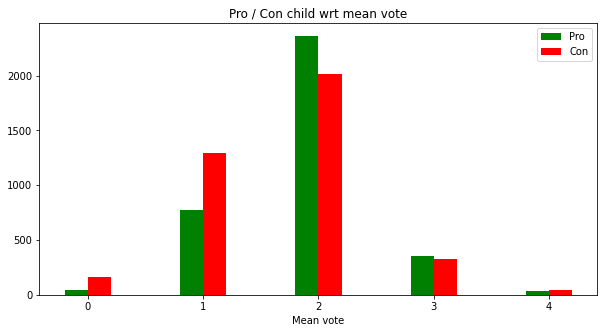

In [ ]:
df_mean_pro_con_total = pd.concat([df_pro_con[['Pro', 'Con']], pd.DataFrame(df['Mean_vote'].values.astype(int), columns=['Mean_vote'])], axis=1) 
df_mean_pro_con_total = df_mean_pro_con_total.groupby(['Mean_vote'], as_index=False).sum()

x = df_mean_pro_con_total['Mean_vote'].values
pro = df_mean_pro_con_total['Pro'].values
con = df_mean_pro_con_total['Con'].values

ax = plt.subplot(111)
ax.bar(x-0.1, pro, width=0.2, color='g', align='center', label='Pro')
ax.bar(x+0.1, con, width=0.2, color='r', align='center', label='Con')

ax.legend()

plt.title(f'Pro / Con child wrt mean vote')
plt.xlabel('Mean vote')

plt.show()

What we can see as a general trend is that if the majoity of children is Con, then the impact is lower, if the majority of children is Pro or balanced, the impact is higher so we decided to add the number of Pro/Con children to the dataframe because it can be an important feature for training

In [ ]:
df = pd.merge(df, df_pro_con, on=['Debate_name', 'Level'])

In [ ]:
# Save dataframe to csv
df.to_csv("dataframe.csv", index=False)

# Final Dataset

In [5]:
df = pd.read_csv('dataframe.csv')

In [6]:
df

,Level,Stance,Claim,Votes,Comments,Depth,Debate_name,Tot_votes,Mean_vote,Parent_claim,Parent_vote,Parent_stance,Pro,Con
0,1.1.1.1,pro,two thirds of all americans and even almost ha...,"[1, 1, 4, 10, 1]",,3,palestine,17,2.5,public opinion in the us supports this step mo...,0.0,pro,1,0
1,1.1.1.1.1,pro,the us historical pattern of vetoing nearly ev...,"[0, 1, 6, 7, 0]",1,4,palestine,14,2.4,two thirds of all americans and even almost ha...,2.5,pro,0,0
2,1.1.1.3.1,pro,by being the first major western country to re...,"[0, 1, 5, 9, 0]",10,4,palestine,15,2.5,the us is one of the world s most influential ...,0.0,pro,0,0
3,1.1.1.3.3,con,the united states is too late to serve as an i...,"[1, 2, 10, 3, 0]",16,4,palestine,16,1.9,the us is one of the world s most influential ...,0.0,pro,0,0
4,1.1.1.4,con,the ignorance of the american people could cau...,"[1, 3, 2, 2, 1]",32,3,palestine,9,1.9,public opinion in the us supports this step mo...,0.0,pro,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494,1.7.4.8.2.3,con,by financing ubi through this system it would ...,"[0, 0, 2, 0, 0]",,5,ubi,2,2.0,a ubi will empower the politically marginalize...,0.0,pro,0,0
9495,1.7.4.8.3.2.1,con,this same logic could also be applied to all o...,"[0, 0, 10, 5, 0]",,6,ubi,15,2.3,if wealthy people already feel as though they ...,0.0,pro,0,0
9496,1.7.4.8.3.2.2,con,what the wealthy want and desire becomes less ...,"[0, 6, 7, 2, 0]",,6,ubi,15,1.7,if wealthy people already feel as though they ...,0.0,pro,0,0
9497,1.7.4.8.3.6,con,those high tax payers already control the stat...,"[0, 0, 1, 1, 0]",,5,ubi,2,2.5,a ubi together with automation will strengthen...,0.0,con,0,0


In [7]:
max_depth_debate = {}
for debate in df['Debate_name'].unique():
  max_depth = df[df['Debate_name'] == debate]['Depth'].max()
  max_depth_debate[debate] = max_depth

In [10]:
def func(row):
  return round((row['Depth'] * 1.0) / max_depth_debate[row['Debate_name']], 1)

In [12]:
df['Depth_norm'] = df.apply(func, axis=1) 

In [58]:
df

,Level,Stance,Claim,Votes,Comments,Depth,Debate_name,Tot_votes,Mean_vote,Parent_claim,Parent_vote,Parent_stance,Pro,Con,Depth_norm
0,1.1.1.1,pro,two thirds of all americans and even almost ha...,"[1, 1, 4, 10, 1]",,3,palestine,17,2.5,public opinion in the us supports this step mo...,0.0,pro,1,0,0.3
1,1.1.1.1.1,pro,the us historical pattern of vetoing nearly ev...,"[0, 1, 6, 7, 0]",1,4,palestine,14,2.4,two thirds of all americans and even almost ha...,2.5,pro,0,0,0.4
2,1.1.1.3.1,pro,by being the first major western country to re...,"[0, 1, 5, 9, 0]",10,4,palestine,15,2.5,the us is one of the world s most influential ...,0.0,pro,0,0,0.4
3,1.1.1.3.3,con,the united states is too late to serve as an i...,"[1, 2, 10, 3, 0]",16,4,palestine,16,1.9,the us is one of the world s most influential ...,0.0,pro,0,0,0.4
4,1.1.1.4,con,the ignorance of the american people could cau...,"[1, 3, 2, 2, 1]",32,3,palestine,9,1.9,public opinion in the us supports this step mo...,0.0,pro,1,0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494,1.7.4.8.2.3,con,by financing ubi through this system it would ...,"[0, 0, 2, 0, 0]",,5,ubi,2,2.0,a ubi will empower the politically marginalize...,0.0,pro,0,0,0.4
9495,1.7.4.8.3.2.1,con,this same logic could also be applied to all o...,"[0, 0, 10, 5, 0]",,6,ubi,15,2.3,if wealthy people already feel as though they ...,0.0,pro,0,0,0.4
9496,1.7.4.8.3.2.2,con,what the wealthy want and desire becomes less ...,"[0, 6, 7, 2, 0]",,6,ubi,15,1.7,if wealthy people already feel as though they ...,0.0,pro,0,0,0.4
9497,1.7.4.8.3.6,con,those high tax payers already control the stat...,"[0, 0, 1, 1, 0]",,5,ubi,2,2.5,a ubi together with automation will strengthen...,0.0,con,0,0,0.4


# Split

In [13]:
# Pandas sample function takes randomly a fraction of the dataframe so we have our debates shuffled in train/valid/test 
train = df.sample(frac=0.95, random_state=42)
tmp = df.drop(train.index)
valid = tmp.sample(frac=0.5, random_state=42)
test = tmp.drop(valid.index)

In [14]:
print(train.shape)
print(valid.shape)
print(test.shape)

(9024, 15)
(238, 15)
(237, 15)


#Dataset Conversion
In this section we define the functions that build the vocabulary of terms contained in Claims and Evidences. In particular the function creates two dictionaries: one to retrieve the index given a word and one to obatain the word given an index.

The function is incremental, so, if it is called without the previously mentioned two dictionaries, it creates new ones while if we already have a vocabulary it enriches it with new unseen words.

We encode at the initialization of the vocabulary the reserved string `-PAD-` with index `0` that will be used, as the name suggest, for the padding.

This vocabulary will be used by the tokenizers in order to translate strings into numerical format so that the NN can accept them as input. 



In [15]:
def build_word_vocabulary(df: pd.DataFrame, word_to_idx=None, idx_to_word=None):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :param idx_to_word: existing vocabulary from index to word
    :param word_to_idx: existing vocabulary from word to index
    
    :return:
      - idx_to_word: updated vocabulary from index to word
      - word_to_idx: updated vocabulary from word to index
      - word listing: set of unique terms that build up the vocabulary
      - max_claim_len: max length among all the claims
      - max_evidence_len: max length among all the evidences
    """

    curr_idx = 1
    # vocabularies must be both evaluated or None
    assert (word_to_idx is None and idx_to_word is None) or (word_to_idx is not None and idx_to_word is not None)

    # If no vocabulary passed, then build one
    if word_to_idx is None and idx_to_word is None:
      idx_to_word = OrderedDict()
      word_to_idx = OrderedDict()
      # Reserved word in the dictionary for padding
      word_to_idx["-PAD-"] = 0
      idx_to_word[0] = "-PAD-"
    else:
      curr_idx = max(idx_to_word.keys()) + 1


    # claim
    max_claim_len = 0
    for sentence in tqdm(df['Claim'].values):
      splitted_sentece = sentence.split(" ")
      max_claim_len = max(len(splitted_sentece), max_claim_len)
      for word in splitted_sentece:
        if word not in word_to_idx:
            word_to_idx[word] = curr_idx
            idx_to_word[curr_idx] = word
            curr_idx += 1

    # parentClaim
    for sentence in tqdm(df['Parent_claim'].values):
      splitted_sentece = sentence.split(" ")
      max_claim_len = max(len(splitted_sentece), max_claim_len)
      for word in splitted_sentece:
        if word not in word_to_idx:
            word_to_idx[word] = curr_idx
            idx_to_word[curr_idx] = word
            curr_idx += 1

    word_listing = list(idx_to_word.values())

    return idx_to_word, word_to_idx, word_listing, max_claim_len
 
# Testing: incremental vocabulary
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(train)
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(valid, word_to_idx, idx_to_word)
idx_to_word, word_to_idx, word_listing, max_claim_len = build_word_vocabulary(test, word_to_idx, idx_to_word)

print("\n")
print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('[Debug] Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10)]))

100%|██████████| 237/237 [00:00<00:00, 23178.35it/s]



[Debug] Index -> Word vocabulary size: 15506
[Debug] Word -> Index vocabulary size: 15506
[Debug] Some words: [('-PAD-', 0), ('there', 1), ('is', 2), ('no', 3), ('reasonable', 4), ('and', 5), ('consistent', 6), ('standard', 7), ('of', 8), ('evidence', 9)]


In [16]:
# Download the glove encoder
import gensim
import gensim.downloader as gloader
embedding_model = gloader.load("glove-wiki-gigaword-50")
embedding_dimension = 50

[==================================================] 100.0% 66.0/66.0MB downloaded


In [17]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

# Testing
oov_terms = check_OOV_terms(embedding_model, word_listing)

Print some statistics:

In [18]:
tot_words = len(word_listing)
tot_OOV = len(oov_terms)
print('Total number of words is:\t{}'.format(tot_words))
print('Total number of OOV words is:\t{}'.format(tot_OOV))
print('Percentage of OOV words w.r.t the whole vocabulary: {:.1f}%'.format(tot_OOV / tot_words * 100))
print('Some oov terms: {}'.format(oov_terms[:5]))

Total number of words is:	15506
Total number of OOV words is:	591
Percentage of OOV words w.r.t the whole vocabulary: 3.8%
Some oov terms: ['zenos', 'bludgers', 'desensitisation', 'inimicum', 'palentologists']


As we expected, there are some oov terms linked to the specificity of the debate, like made-up words related to the Harry Potter world.

We then define the function that builds the embedding matrix.

The embedding matrix is stored inside a parameter of the tokenizer and will be passed later to the embedding layer in order to retrieve the embedding vectors.

The function is called on the entire vocabulary each time it is updated with new words. In particular it checks if, in the pre-trained embedding model, a given word is present or not. If not so, the function generates a random vector with values in the bound [-0.05, 0.05] and same size of the choosen model. In the end the embedding vector is inserted into the matrix in the line corresponding to the index of that word in the vocabulary in order to match with the numeric input of the NN.

In [19]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding dimension: fixed integer embedding dimension 
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        # If the word is not in the vocabulary, associate a random embedding vector, and save it in the embedding matrix
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

# Testing
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, len(word_to_idx), oov_terms)
# print("\nEmbedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 15506/15506 [00:00<00:00, 259151.33it/s]


In [20]:
class Tokenizer(object):
    """ 
      A simple tokenizer that uses the functions: 
      - build_word_vocabulary
      - check_OOV_terms
      - build_embedding_matrix
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None, embedding_model=None):
        if build_embedding_matrix:
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model = embedding_model

        self.embedding_matrix = None
        self.word_to_idx = None
        self.idx_to_word = None

    def build_vocab(self, data, **kwargs):
        #first time with None -> create, otherwise update vocabulary
        self.idx_to_word, self.word_to_idx, word_listing, _ = build_word_vocabulary(data, self.word_to_idx, self.idx_to_word)

        if self.build_embedding_matrix:
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=word_listing)

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.word_to_idx,
                                                           vocab_size=len(self.word_to_idx),        
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.word_to_idx),
        }


    def convert_words_to_ids(self, words):
      return [self.word_to_idx[word] for word in words]

    def convert_ids_to_words(self, ids):
      return [self.idx_to_word[id] for id in ids] 

Using the tokenizer we build incrementally the vocabulary and update the embedding matrix:

In [21]:
# Instantiate the tokenizer (V1)
tokenizer = Tokenizer(build_embedding_matrix=True,
                      embedding_dimension=embedding_dimension,
                      embedding_model=embedding_model)

# BUILDING V2 = V1 + train OOV
tokenizer.build_vocab(train)
print(f'Vocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

# BUILDING V3 = V2 + valid OOV
tokenizer.build_vocab(valid)
print(f'Vocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

# BUILDING V4 = V3 + test OOV
tokenizer.build_vocab(test)
print(f'\nVocabulary size: {tokenizer.get_info()["vocab_size"]}\n')

100%|██████████| 9024/9024 [00:00<00:00, 197893.97it/s]


Checking OOV terms...
Building the embedding matrix...


100%|██████████| 15257/15257 [00:00<00:00, 190320.18it/s]


Vocabulary size: 15257



100%|██████████| 238/238 [00:00<00:00, 140360.57it/s]


Checking OOV terms...
Building the embedding matrix...


100%|██████████| 15377/15377 [00:00<00:00, 245039.29it/s]


Vocabulary size: 15377



100%|██████████| 237/237 [00:00<00:00, 134476.47it/s]


Checking OOV terms...
Building the embedding matrix...


100%|██████████| 15506/15506 [00:00<00:00, 197220.70it/s]


Vocabulary size: 15506



We also define two function to encode the labels into numbers (binary) and vice versa

In [28]:
def label2idx(label):
  return {
        'pro': 1,
        'con': 0,
        'None': 1 # We arbitrary decided that the stance of the main claim is pro
  }[label]

def idx2label(idx):
  return {
        1: 'pro',
        0: 'con',
  }[idx]

And we split the dataset into claims set, evidences set and label set for train/valid/test 

In [22]:
# train
claim_train = [sentence.split(" ") for sentence in train['Claim'].values]
claim_parent_train = [sentence.split(" ") for sentence in train['Parent_claim'].values]
parent_vote_train = train['Parent_vote'].values
n_child_pro_train = train['Pro'].values
n_child_con_train = train['Con'].values
depth_train = train['Depth_norm'].values
stance_train = train['Stance']
y_train = train['Mean_vote']

# valid
claim_val = [sentence.split(" ") for sentence in valid['Claim'].values]
claim_parent_val = [sentence.split(" ") for sentence in valid['Parent_claim'].values]
parent_vote_val = valid['Parent_vote'].values
n_child_pro_val = valid['Pro'].values
n_child_con_val = valid['Con'].values
depth_val = valid['Depth_norm'].values
stance_val = valid['Stance']
y_val = valid['Mean_vote']

# test
claim_test = [sentence.split(" ") for sentence in test['Claim'].values]
claim_parent_test = [sentence.split(" ") for sentence in test['Parent_claim'].values]
parent_vote_test = test['Parent_vote'].values
n_child_pro_test = test['Pro'].values
n_child_con_test = test['Con'].values
depth_test = test['Depth_norm'].values
stance_test = test['Stance']
y_test = test['Mean_vote']

In [23]:
idx_to_show =  7138 #@param {type:"slider", min:0, max:9023, step:1}
print('Choosen claim of the training set:')
print(claim_train[idx_to_show])
print('Choosen parent claim of the training set:')
print(claim_parent_train[idx_to_show])
print('\nChoosen stance of the training set:')
print(stance_train[idx_to_show])
print('\nChoosen number of pro children of the training set:')
print(n_child_pro_train[idx_to_show])
print('\nChoosen number of con children of the training set:')
print(n_child_con_train[idx_to_show])
print('\nChoosen label of the training set:')
print(y_train[idx_to_show])

Choosen claim of the training set:
['the', 'capacity', 'for', 'harm', 'is', 'greater', 'when', 'magic', 'is', 'involved']
Choosen parent claim of the training set:
['would', 'we', 'like', 'to', 'live', 'in', 'the', 'world', 'of', 'harry', 'potter']

Choosen stance of the training set:
pro

Choosen number of pro children of the training set:
3

Choosen number of con children of the training set:
4

Choosen label of the training set:
1.5


Finally we encode the inputs of our model and the output label to do the evaluation steps.

We accomplish this task using two functions that convert claims, evidences and labels into a numerical format using the previously defined tokenizer and functions.

The function also pads claims and evidences using zeroes (the encoding of the `-PAD-` string defined in the initialization of the vocabularies) so that they all have the same size.

The maximum length of the sequences is determined by the training set in order to emulate a real scenario where the test set can also have longer sequences than the ones used to train the network. In case a claim or an evidence exceeds that dimension, it is truncated.

In [24]:
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :param tokenizer: an instantiated tokenizer
    :param is_training: whether input texts are from the training split or not
    :param max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = [tokenizer.convert_words_to_ids(sentence) for sentence in texts]

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

Convert claim

In [25]:
# Train
claim_train, max_tokens = convert_text(claim_train, tokenizer, True)
print("Max sequence length: {}\n".format(max_tokens))
print('X train shape: ', claim_train.shape)

# Val
claim_val = convert_text(claim_val, tokenizer, False, max_tokens)
print('X val shape: ', claim_val.shape)

# Test
claim_test = convert_text(claim_test, tokenizer, False, max_tokens)
print('X test shape: ', claim_test.shape)

Max sequence length: 76

X train shape:  (9024, 76)
X val shape:  (238, 76)
X test shape:  (237, 76)


Convert parent claim

In [26]:
# Train
claim_parent_train = convert_text(claim_parent_train, tokenizer, False, max_tokens)
print("Max sequence length: {}\n".format(max_tokens))
print('X train shape: ', claim_parent_train.shape)

# Val
claim_parent_val = convert_text(claim_parent_val, tokenizer, False, max_tokens)
print('X val shape: ', claim_parent_val.shape)

# Test
claim_parent_test = convert_text(claim_parent_test, tokenizer, False, max_tokens)
print('X test shape: ', claim_parent_test.shape)

Max sequence length: 76

X train shape:  (9024, 76)
X val shape:  (238, 76)
X test shape:  (237, 76)


Convert stance

In [29]:
# Train
stance_train = stance_train.apply(label2idx).values
print('Y train shape: ', stance_train.shape)

# Val
stance_val = stance_val.apply(label2idx).values
print('Y valid shape: ', stance_val.shape)

# Test
stance_test = stance_test.apply(label2idx).values
print('Y test shape: ', stance_test.shape)

Y train shape:  (9024,)
Y valid shape:  (238,)
Y test shape:  (237,)


In [30]:
idx_to_show =  1043 #@param {type:"slider", min:0, max:9023, step:1}
print('Choosen claim of the training set:')
print(claim_train[idx_to_show])
print('Choosen parent claim of the training set:')
print(claim_parent_train[idx_to_show])
print('\nChoosen stance of the training set:')
print(stance_train[idx_to_show])
print('\nChoosen number of pro children of the training set:')
print(n_child_pro_train[idx_to_show])
print('\nChoosen number of con children of the training set:')
print(n_child_con_train[idx_to_show])
print('\nChoosen label of the training set:')
print(y_train[idx_to_show])

Choosen claim of the training set:
[2823  139 5343   10  182  637    5 4159 4160   55  863 4365   19 3265
 3515  182 2842    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
Choosen parent claim of the training set:
[ 182  133  607   32 1961  433   15  657 1977    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

Choosen stance of the training set:
0

Choosen number of pro children of the training set:
1

Choosen number of con children of the training set:
0


# Model definition and training

## Embedding strategy

In [ ]:
class RNNSentenceEmbedding(tf.keras.layers.Layer):
    """
    Create a recurrent sentence embedding layer that using a bidirectional LSTM

    :param embedding_dim: the dimension of the embedding vector
    :param average_all_outputs: if True the entire sequence of the bidirectional
      LSTM is returned and then all the output vectors are averaged, otherwise
      only the last output is returned

    :return
      the sentence embedding vector
    """
    def __init__(self, embedding_dim, average_all_outputs=False, **kwargs):
        super(RNNSentenceEmbedding, self).__init__(**kwargs)
        self.average_all_outputs = average_all_outputs
        self.lstm = Bidirectional(LSTM(embedding_dim, return_sequences=self.average_all_outputs))
        
    def call(self, inputs, average=False): 
        if self.average_all_outputs:
            return tf.reduce_mean(self.lstm(inputs), axis=1)
        else:
            return self.lstm(inputs)

## Concatenation strategy

In [ ]:
class ConcatationMerge(tf.keras.layers.Layer):
  def call(self, claim_sentence_embedding, evidence_sentence_embedding, **kwargs):
      cosine_similarity = Dot(axes=1, normalize=True)([claim_sentence_embedding, evidence_sentence_embedding])
      merged = Concatenate()([claim_sentence_embedding, evidence_sentence_embedding])
      return Concatenate()([merged, cosine_similarity])

## Training functions

In [ ]:
word_embedding_info = {
      "output_dim": embedding_dimension,
      "input_dim": tokenizer.get_info()['vocab_size'],
      "input_length": max_tokens,
      "weights": tokenizer.embedding_matrix if tokenizer.embedding_matrix is None else [tokenizer.embedding_matrix],
      "mask_zero": False,
      "trainable": False
    }

In [ ]:
training_info = {
    'verbose': 1,
    'epochs': 100,
    'batch_size': 64,
    'callbacks': [
      keras.callbacks.EarlyStopping(monitor='val_loss',
                                    mode='min',
                                    patience=5, 
                                    restore_best_weights=True)]
}

In [ ]:
#Plots some graphs on training history
def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()

#Train the model
def train_model(model: keras.Model,
                x_train: np.ndarray,
                y_train: np.ndarray,
                x_val: np.ndarray,
                y_val: np.ndarray,
                training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param x_train: training data in np.ndarray format
    :param y_train: training labels in np.ndarray format
    :param x_val: validation data in np.ndarray format
    :param y_val: validation labels in np.ndarray format
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training! \nParameters: {}".format(training_info))
    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed! Showing history...")

    show_history(history)

    return model

## Models implementation

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dot, Concatenate, Add, Average, Dense, Dropout, Flatten

### Model 0
In this model use only the claim to predict its impact

In [ ]:
def create_model0(sentence_embedding, merging_strategy):
    
    # Claim input embedding
    claim_input = Input(shape=(max_tokens,), name="claim_input")
    claim_word_embedding = Embedding(**word_embedding_info, name="claim_word_embedding")(claim_input)
    claim_sentence_embedding = sentence_embedding(claim_word_embedding)

    # Regressor
    dense_layer = Dense(50, activation="relu", name="dense")(claim_sentence_embedding)
    output_class = Dense(1, activation="relu", name="regressor")(dense_layer)

    model = keras.Model(inputs=claim_input, outputs=output_class)

    model.summary()

    # Compile
    model.compile(loss='mae', metrics=['mae'],
                  optimizer=keras.optimizers.Adam(1e-4))

    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 claim_input (InputLayer)    [(None, 76)]              0         
                                                                 
 claim_word_embedding (Embed  (None, 76, 50)           775300    
 ding)                                                           
                                                                 
 sentence_embedding (RNNSent  (None, 100)              40400     
 enceEmbedding)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 regressor (Dense)           (None, 1)                 51        
                                                                 
Total params: 820,801
Trainable params: 45,501
Non-trainable 

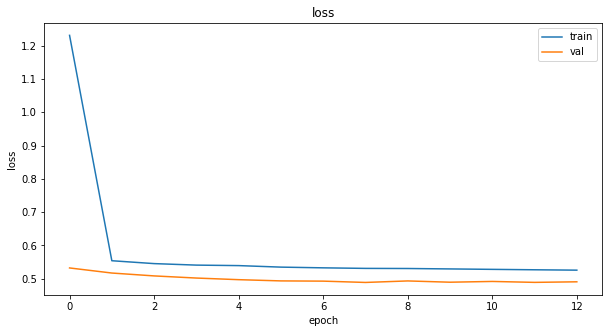

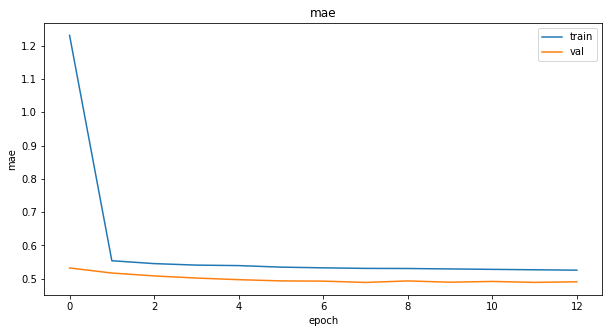

In [ ]:
model0 = create_model0(sentence_embedding=RNNSentenceEmbedding(embedding_dimension, False, name='sentence_embedding'), 
                       merging_strategy=ConcatationMerge(name="merging_strategy"))

model0 = train_model(model=model0, x_train=claim_train, y_train=y_train,
                    x_val=claim_val, y_val=y_val, training_info=training_info)

### Model 1
In this model we merge the embedding of the selected **claim** with the embedding of the **parent claim**

In [ ]:
def create_model1(sentence_embedding, merging_strategy):
    
    # Claim input embedding
    claim_input = Input(shape=(max_tokens,), name="claim_input")
    claim_word_embedding = Embedding(**word_embedding_info, name="claim_word_embedding")(claim_input)
    claim_sentence_embedding = sentence_embedding(claim_word_embedding)

    claim_parent_input = Input(shape=(max_tokens,), name='claim_parent_input')
    claim_parent_word_embedding = Embedding(**word_embedding_info, name="claim_parent_word_embedding")(claim_parent_input)
    claim_parent_sentence_embedding = sentence_embedding(claim_parent_word_embedding)

    # Merging
    merge_layer = merging_strategy(claim_sentence_embedding, claim_parent_sentence_embedding)

    # Regressor
    dense_layer = Dense(50, activation="relu", name="dense")(merge_layer)
    output_class = Dense(1, activation="relu", name="regressor")(dense_layer)

    model = keras.Model(inputs=[claim_input, claim_parent_input], outputs=output_class)

    model.summary()

    # Compile
    model.compile(loss='mae', metrics=['mae'],
                  optimizer=keras.optimizers.Adam(1e-4))

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 claim_parent_input (InputLayer  [(None, 76)]        0           []                               
 )                                                                                                
                                                                                                  
 claim_word_embedding (Embeddin  (None, 76, 50)      775300      ['claim_input[0][0]']            
 g)                                                                                               
                                                                                            

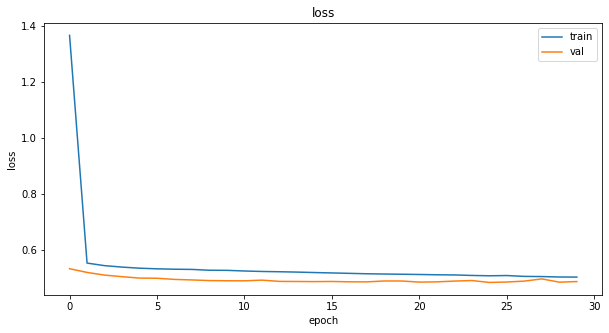

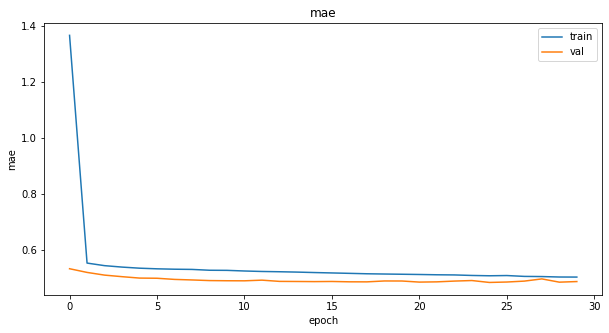

In [ ]:
model1 = create_model1(sentence_embedding=RNNSentenceEmbedding(embedding_dimension, False, name='sentence_embedding'), 
                       merging_strategy=ConcatationMerge(name="merging_strategy"))

model1 = train_model(model=model1, x_train=[claim_train, claim_parent_train], y_train=y_train,
                    x_val=[claim_val, claim_parent_val], y_val=y_val, training_info=training_info)

### Model 2
In this model we merge the embedding of the selected **claim** with the embedding of the **parent claim** and then concatenate the claim stance and the impact of the parent because we thought that if the parent has a bad impact, the current claim would have higher impact if it has stance Con, vice-versa, if the parent has an high impact, if the current claim stance is Pro then it would have high impact too.

In [ ]:
def create_model2(sentence_embedding, merging_strategy):
    
    # Claim input embedding
    claim_input = Input(shape=(max_tokens,), name="claim_input")
    claim_word_embedding = Embedding(**word_embedding_info, name="claim_word_embedding")(claim_input)
    claim_sentence_embedding = sentence_embedding(claim_word_embedding)

    claim_parent_input = Input(shape=(max_tokens,), name='claim_parent_input')
    claim_parent_word_embedding = Embedding(**word_embedding_info, name="claim_parent_word_embedding")(claim_parent_input)
    claim_parent_sentence_embedding = sentence_embedding(claim_parent_word_embedding)

    # Merging
    merge_layer = merging_strategy(claim_sentence_embedding, claim_parent_sentence_embedding)

    # Claim stance input
    stance_input = Input(shape=(1,), name='stance_input')

    # Parent vote input
    parent_vote_input = Input(shape=(1,), name='parent_vote_input')

    # Concatenation
    concatenation_layer = Concatenate()([merge_layer, stance_input, parent_vote_input])

    # Regressor
    dense_layer = Dense(50, activation="relu", name="dense")(concatenation_layer)
    output_class = Dense(1, activation="relu", name="regressor")(dense_layer)

    model = keras.Model(inputs=[claim_input, claim_parent_input, stance_input, parent_vote_input], outputs=output_class)

    model.summary()

    # Compile
    model.compile(loss='mae', metrics=['mae'],
                  optimizer=keras.optimizers.Adam(1e-4))

    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 claim_parent_input (InputLayer  [(None, 76)]        0           []                               
 )                                                                                                
                                                                                                  
 claim_word_embedding (Embeddin  (None, 76, 50)      775300      ['claim_input[0][0]']            
 g)                                                                                               
                                                                                            

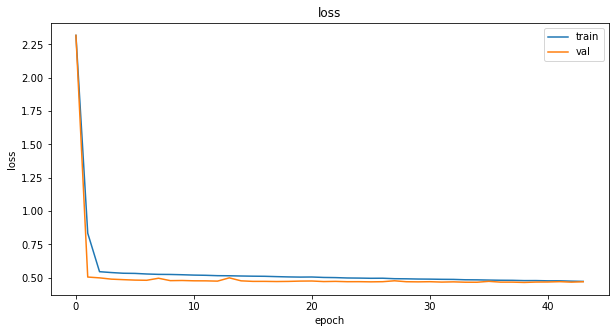

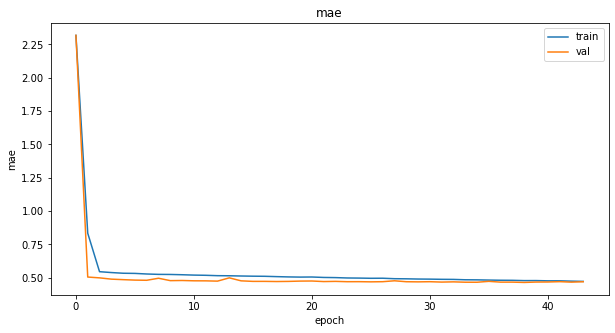

In [ ]:
model2 = create_model2(sentence_embedding=RNNSentenceEmbedding(embedding_dimension, False, name='sentence_embedding'), 
                       merging_strategy=ConcatationMerge(name="merging_strategy"))

model2 = train_model(model=model2, x_train=[claim_train, claim_parent_train, stance_train, parent_vote_train], y_train=y_train,
                    x_val=[claim_val, claim_parent_val, stance_val, parent_vote_val], y_val=y_val, training_info=training_info)

### Model 3
In this model we merge the embedding of the selected **claim** with the embedding of the **parent claim** and then concatenate the claim stance, the impact of the parent and the ratio of pro/con childs

In [ ]:
def create_model3(sentence_embedding, merging_strategy):
    
    # Claim input embedding
    claim_input = Input(shape=(max_tokens,), name="claim_input")
    claim_word_embedding = Embedding(**word_embedding_info, name="claim_word_embedding")(claim_input)
    claim_sentence_embedding = sentence_embedding(claim_word_embedding)

    claim_parent_input = Input(shape=(max_tokens,), name='claim_parent_input')
    claim_parent_word_embedding = Embedding(**word_embedding_info, name="claim_parent_word_embedding")(claim_parent_input)
    claim_parent_sentence_embedding = sentence_embedding(claim_parent_word_embedding)

    # Merging
    merge_layer = merging_strategy(claim_sentence_embedding, claim_parent_sentence_embedding)

    # Claim stance input
    stance_input = Input(shape=(1,), name='stance_input')

    # Parent vote input
    parent_vote_input = Input(shape=(1,), name='parent_vote_input')

    # Childs ratio input
    n_child_ratio_input = Input(shape=(1,), name='n_child_ratio_input')

    # Concatenation
    concatenation_layer = Concatenate()([merge_layer, stance_input, parent_vote_input, n_child_ratio_input])

    # Regressor
    dense_layer = Dense(50, activation="relu", name="dense")(concatenation_layer)
    output_class = Dense(1, activation="relu", name="regressor")(dense_layer)

    model = keras.Model(inputs=[claim_input, claim_parent_input, stance_input, parent_vote_input, n_child_ratio_input], outputs=output_class)

    model.summary()

    # Compile
    model.compile(loss='mae', metrics=['mae'],
                  optimizer=keras.optimizers.Adam(1e-4))

    return model

In [32]:
n_child_ratio_train = (n_child_pro_train + 1.0) / (n_child_con_train + 1.0)
n_child_ratio_val = (n_child_pro_val + 1.0) / (n_child_con_val + 1.0)
n_child_ratio_test = (n_child_pro_test + 1.0) / (n_child_con_test + 1.0)

In [ ]:
n_child_ratio_train = n_child_pro_train - n_child_con_train
n_child_ratio_val = n_child_pro_val - n_child_con_val
n_child_ratio_test = n_child_pro_test - n_child_con_test

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 76)]         0           []                               
                                                                                                  
 claim_parent_input (InputLayer  [(None, 76)]        0           []                               
 )                                                                                                
                                                                                                  
 claim_word_embedding (Embeddin  (None, 76, 50)      775300      ['claim_input[0][0]']            
 g)                                                                                               
                                                                                            

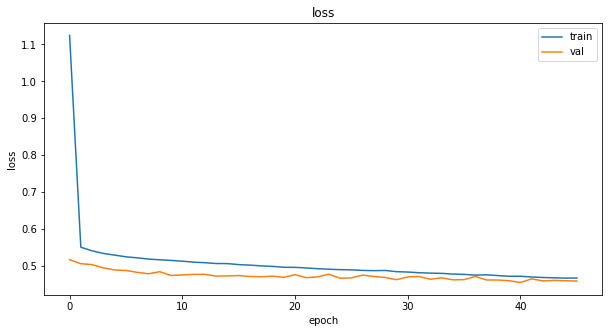

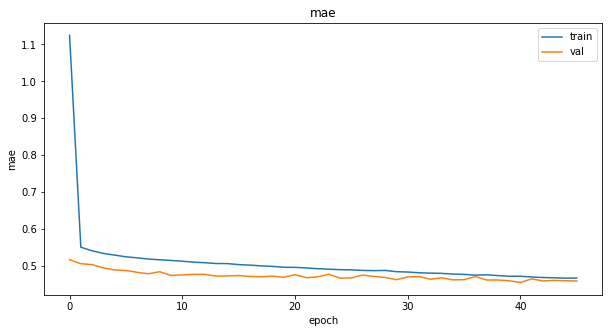

In [ ]:
model3 = create_model3(sentence_embedding=RNNSentenceEmbedding(embedding_dimension, False, name='sentence_embedding'), 
                       merging_strategy=ConcatationMerge(name="merging_strategy"))

model3 = train_model(model=model3, x_train=[claim_train, claim_parent_train, stance_train, parent_vote_train, n_child_ratio_train], y_train=y_train,
                    x_val=[claim_val, claim_parent_val, stance_val, parent_vote_val, n_child_ratio_val], y_val=y_val, training_info=training_info)

# Evaluation

In [24]:
def predict_data(model: keras.Model,
                 x: np.ndarray,
                 prediction_info: Dict) -> np.ndarray:
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """

    #print('Starting prediction: \n{}'.format(prediction_info))
    #print('Predicting on {} samples'.format(x.shape[0]))

    predictions = model.predict(x, **prediction_info)
    return predictions


def evaluate_predictions(predictions: np.ndarray,
                         y: np.ndarray,
                         metrics: List[Callable],
                         metric_names: List[str]):
    """
    Evaluates given model predictions on a list of metric functions

    :param predictions: model predictions in np.ndarray format
    :param y: ground-truth labels in np.ndarray format
    :param metrics: list of metric functions
    :param metric_names: list of metric names

    :return
        metric_info: dictionary containing metric values for each input metric
    """

    assert len(metrics) == len(metric_names)

    print("Evaluating predictions! Total samples: ", y.shape[0])

    metric_info = {}
    for metric, metric_name in zip(metrics, metric_names):
        all_metric_values = metric
        metric_value = np.mean([ metric(y_true, [y_pred]) for y_true, y_pred in zip(y, predictions) ])
        metric_info[metric_name] = metric_value

    return metric_info

## Model 0

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=model0, x=[claim_test], prediction_info=prediction_info)

eval = evaluate_predictions(test_predictions, y_test, [tf.keras.metrics.MeanAbsoluteError()], ['mae'])
print(f"Mean absolute error: {eval['mae']:.4f}")

4/4 [==============================] - 0s 13ms/step
Evaluating predictions! Total samples:  237
Mean absolute error: 0.4167


## Model 1

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=model1, x=[claim_test, claim_parent_test], prediction_info=prediction_info)

eval = evaluate_predictions(test_predictions, y_test, [tf.keras.metrics.MeanAbsoluteError()], ['mae'])
print(f"Mean absolute error: {eval['mae']:.4f}")

4/4 [==============================] - 3s 25ms/step
Evaluating predictions! Total samples:  237
Mean absolute error: 0.4257


## Model 2

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=model2, x=[claim_test, claim_parent_test, stance_test, parent_vote_test], prediction_info=prediction_info)

eval = evaluate_predictions(test_predictions, y_test, [tf.keras.metrics.MeanAbsoluteError()], ['mae'])
print(f"Mean absolute error: {eval['mae']:.4f}")

4/4 [==============================] - 0s 24ms/step
Evaluating predictions! Total samples:  237
Mean absolute error: 0.4068


## Model 3

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions = predict_data(model=model3, x=[claim_test, claim_parent_test, stance_test, parent_vote_test, n_child_ratio_test], prediction_info=prediction_info)

eval = evaluate_predictions(test_predictions, y_test, [tf.keras.metrics.MeanAbsoluteError()], ['mae'])
print(f"Mean absolute error: {eval['mae']:.4f}")

4/4 [==============================] - 0s 23ms/step
Evaluating predictions! Total samples:  237
Mean absolute error: 0.4141


## Show prediction of best model

In [ ]:
# Inference
prediction_info = {
    'batch_size': 64,
    'verbose': 1
}
test_predictions =  predict_data(model=model2, x=[claim_test, claim_parent_test, stance_test, parent_vote_test], prediction_info=prediction_info)

print(test_predictions.shape)
print(y_test.shape)

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

print("\n".join(f"Predict: {y_pred[0]:.1f}\t real {y}" for y_pred, y in zip(test_predictions, y_test)))

4/4 [==============================] - 0s 24ms/step
(237, 1)
(237,)
Predict: 2.2	 real 2.4
Predict: 2.3	 real 2.2
Predict: 2.1	 real 1.7
Predict: 2.6	 real 2.4
Predict: 2.6	 real 1.8
Predict: 2.6	 real 1.9
Predict: 2.4	 real 2.5
Predict: 2.2	 real 2.5
Predict: 2.1	 real 1.0
Predict: 2.6	 real 3.0
Predict: 2.8	 real 2.6
Predict: 2.5	 real 2.7
Predict: 2.6	 real 3.4
Predict: 2.7	 real 2.4
Predict: 2.6	 real 3.5
Predict: 2.4	 real 2.3
Predict: 2.4	 real 2.4
Predict: 2.2	 real 2.5
Predict: 2.4	 real 1.3
Predict: 2.4	 real 2.0
Predict: 2.6	 real 2.0
Predict: 2.1	 real 2.3
Predict: 2.1	 real 1.7
Predict: 2.2	 real 1.8
Predict: 2.1	 real 2.2
Predict: 2.3	 real 1.3
Predict: 2.2	 real 2.4
Predict: 2.4	 real 3.2
Predict: 2.7	 real 2.6
Predict: 2.6	 real 2.0
Predict: 2.3	 real 2.9
Predict: 2.1	 real 1.7
Predict: 2.4	 real 2.1
Predict: 2.4	 real 1.5
Predict: 2.5	 real 3.0
Predict: 2.1	 real 2.3
Predict: 2.1	 real 2.3
Predict: 2.3	 real 2.0
Predict: 2.2	 real 2.0
Predict: 2.2	 real 2.3
Predict: 2.4

# Machine Learning Techniques

In [ ]:
from sklearn.metrics import mean_absolute_error

In [95]:
X_train = np.column_stack((depth_train, stance_train, parent_vote_train, n_child_ratio_train))
X_test = np.column_stack((depth_test, stance_test, parent_vote_test, n_child_ratio_test))

####Linear Regression

In [96]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")

Mean absolute error: 0.5026


####Polynomial Regression

In [97]:
from sklearn.preprocessing import PolynomialFeatures

# define the pipeline and train model 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)
poly.fit(X_poly, y_train)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)

y_pred = lin_reg.predict(poly.fit_transform(X_test))

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")

Mean absolute error: 0.4867


####Robust Regression - RANSAC

In [71]:
from sklearn.linear_model import RANSACRegressor

# Set RANSAC hyperparameters
ransac = RANSACRegressor(LinearRegression(),
		max_trials=4, 		# Number of Iterations
		min_samples=2, 		# Minimum size of the sample
		loss='absolute_loss', 	# Metrics for loss
		residual_threshold=10 	# Threshold
		)

# Train model
ransac.fit(X_train, y_train)

y_pred = ransac.predict(X_test)
#print('predicted response:', y_pred, sep='\n')

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")
#print("\n".join("{} {}".format(x, y) for x, y in zip(y_pred, y_test)))

Mean absolute error: 0.5026


####Decision Tree Regressor

Mean absolute error: 0.4496
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.45242 to fit


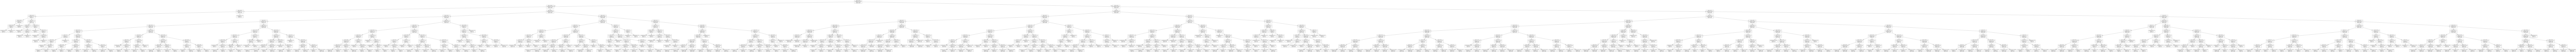

In [75]:
from sklearn.tree import DecisionTreeRegressor
import graphviz 
from sklearn.tree import export_graphviz
from IPython.display import Image

# Build decision tree
tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")

dot_data = export_graphviz(tree, out_file="tree.dot") 
graph = graphviz.Source(dot_data)
! dot -Tpng tree.dot -o tree.png
Image(filename='tree.png')

####Random Forest Regression

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# define used regressor
clf = GridSearchCV(RandomForestRegressor(), {'max_depth': list(range(1,20)), 
                                             'n_estimators': list(range(10,20)), 
                                             'criterion': ['mse']}, 
                   cv=5, n_jobs=-1)
'''
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )
'''                          

# train model
clf.fit(claim_train, y_train)
best_params = clf.best_params_
print(best_params)

'''
y_pred = tree.predict(claim_test)

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")
'''

KeyboardInterrupt: ignored

In [92]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest = RandomForestRegressor(n_estimators=20, max_depth=10, criterion='mse')

# train model
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")

Mean absolute error: 0.4466


####SVM Regression

In [100]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

X_train = np.column_stack((depth_train, stance_train, parent_vote_train, n_child_ratio_train))

# Choose regression method and set hyperparameter
svr_rbf=SVR(C=1.0, epsilon=0.2, kernel='rbf')

# Training of the regression model
svr_rbf.fit(X_train, y_train)

X_test = np.column_stack((depth_test, stance_test, parent_vote_test, n_child_ratio_test))
y_pred = svr_rbf.predict(X_test)

mae_ml = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae_ml:.4f}")

Mean absolute error: 0.4535
